# Optimization pipeline

## Processing land use

<Axes: >

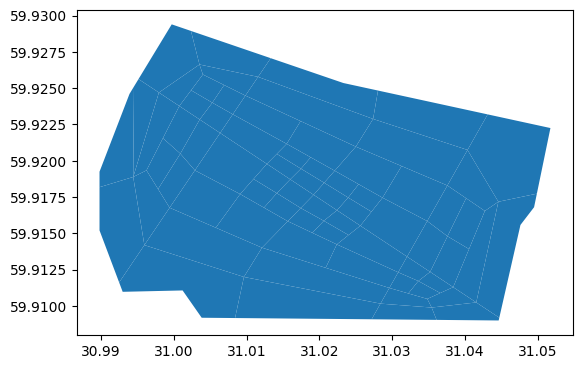

In [6]:
import geopandas as gpd

gpd.read_file('./data/blocks.geojson').plot()

In [1]:
import geopandas as gpd

blocks = gpd.read_parquet('./data/blocks.parquet')
zones = gpd.read_parquet('./data/PZZ_2023.parquet').to_crs(blocks.crs).rename(columns={'functional_zone_type_name': 'zone'})

In [ ]:
from lu_igi.models.land_use import LandUse

land_use_names_mapping = {
    'residential' : LandUse.RESIDENTIAL,
    'recreation' : LandUse.RECREATION,
    'special' : LandUse.SPECIAL,
    'industrial' : LandUse.INDUSTRIAL,
    'agriculture' : LandUse.AGRICULTURE,
    'transport' : LandUse.TRANSPORT,
    'business' : LandUse.BUSINESS,
    'residential_individual' : LandUse.RESIDENTIAL,
    'residential_lowrise' : LandUse.RESIDENTIAL,
    'residential_midrise' : LandUse.RESIDENTIAL,
    'residential_multistorey' : LandUse.RESIDENTIAL,
}

In [ ]:
from lu_igi.preprocessing.land_use import process_land_use

blocks = process_land_use(blocks, zones, land_use_names_mapping, min_intersection_share=0.3)
blocks

2025-02-08 20:42:06.077 | INFO     | lu_igi.preprocessing.land_use:_validate_input:19 - Validating input
2025-02-08 20:42:06.106 | INFO     | lu_igi.preprocessing.land_use:_process_zones:26 - Processing functional zones
2025-02-08 20:42:06.109 | INFO     | lu_igi.preprocessing.land_use:process_land_use:35 - Intersecting geometries


KeyboardInterrupt: 

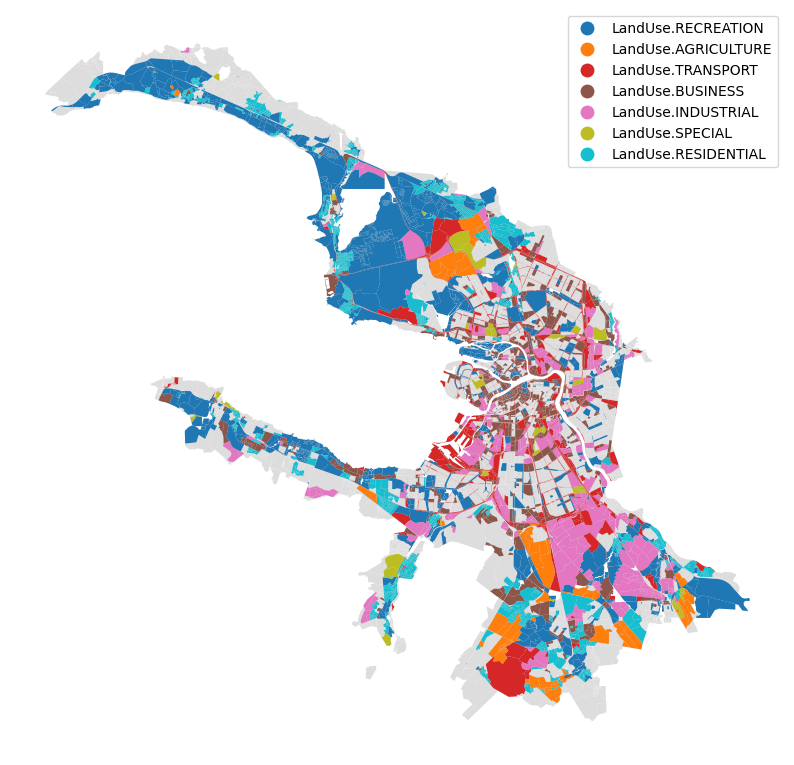

In [ ]:
ax = blocks.plot(color='#ddd', figsize=(10,10))
blocks.plot(ax=ax, column='land_use', legend=True)
ax.set_axis_off()

## Generating adjacency graph

In [ ]:
from lu_igi.preprocessing.graph import generate_adjacency_graph, save_graph, load_graph

graph = generate_adjacency_graph(blocks)

2025-02-08 20:27:38.608 | INFO     | lu_igi.preprocessing.graph:generate_adjacency_graph:65 - Validating input
2025-02-08 20:27:39.337 | INFO     | lu_igi.preprocessing.graph:_generate_adjacency_edges:47 - Generating edges
100%|██████████| 106850/106850 [00:10<00:00, 10641.30it/s]
2025-02-08 20:27:54.839 | SUCCESS  | lu_igi.preprocessing.graph:generate_adjacency_graph:79 - Graph successfully generated


In [ ]:
save_graph(graph, './graph.pickle')

In [ ]:
graph.graph

{'epsg': 32636}

## Optimization